In [161]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import bbobtorch
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
import gt_sampling
import torch.optim as optim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [12]:
# generate ground truth from BBOB function suite
n_dim = 2
problem = bbobtorch.create_f24(n_dim, seed=42)

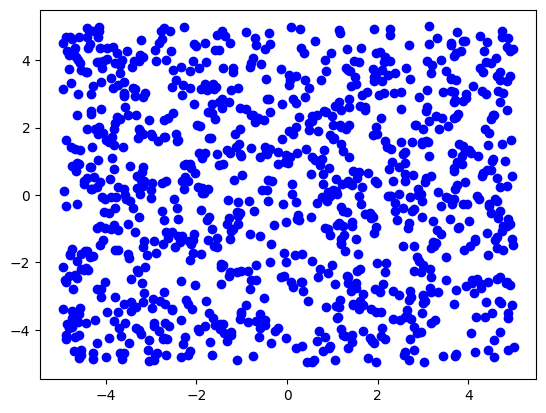

In [13]:
samples = gt_sampling.get_sample(f_number=3, n_samples=1000, n_dim=2, seed=42, method='random')
plt.plot(samples[:, 0],samples[:, 1],'bo')

In [14]:
# convert the samples into the right format for the problem:
custom_samples_double = torch.tensor(samples, dtype=torch.float64)
custom_samples_float32 = custom_samples_double.float()

# get the results from the bbob problem:
results = problem(custom_samples_float32)


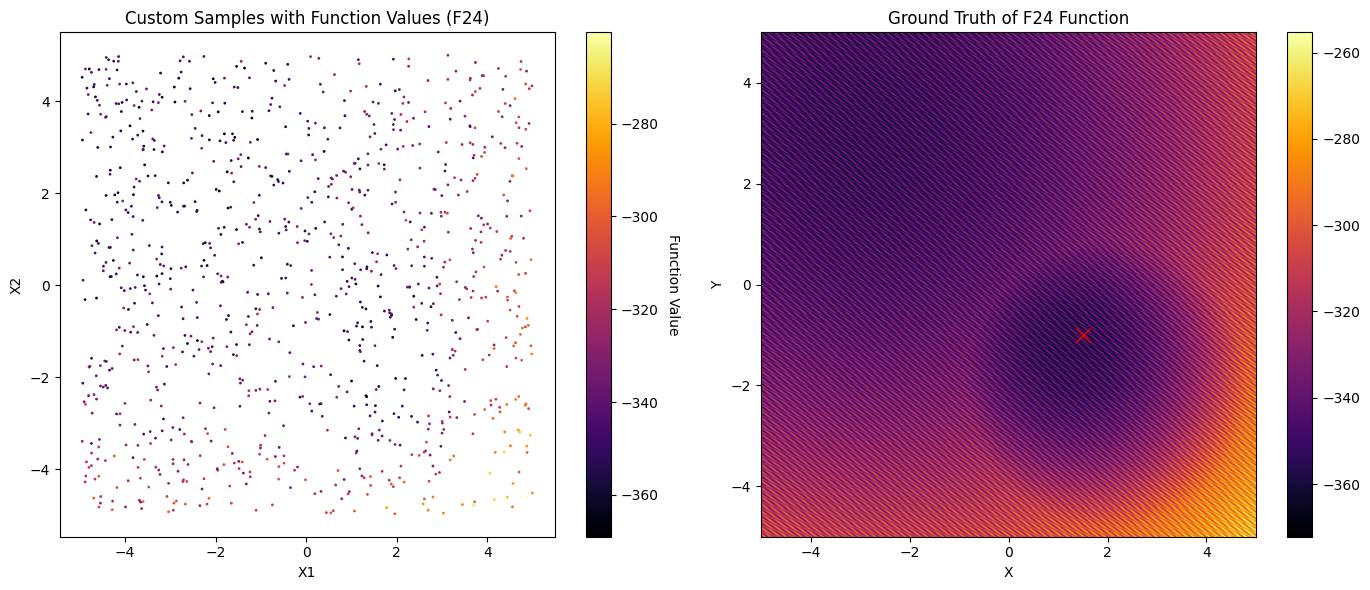

In [15]:
# Create a scatter plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

plt.scatter(samples[:, 0], samples[:, 1], c=results, cmap='inferno', s=1)

# Add color bar for reference
colorbar = plt.colorbar()
colorbar.set_label('Function Value', rotation=270, labelpad=15)

# Add labels and title
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Custom Samples with Function Values (F24)')

# Plot the ground truth using a contour plot

plt.subplot(1, 2, 2)
xlim=(-5, 5)
step=0.01
ranges = [torch.arange(xlim[0], xlim[1] + step, step=step) for _ in range(n_dim)]
meshgrid = torch.meshgrid(*ranges)
points = torch.stack(meshgrid, dim=-1).view(-1, n_dim)

gt_results = problem(points)

grid_size = int((xlim[1] - xlim[0]) / step) + 1
x = points[:, 0].reshape(grid_size, grid_size)
y = points[:, 1].reshape(grid_size, grid_size)
z = gt_results.reshape(grid_size, grid_size)

# Create a pcolormesh plot
plt.pcolormesh(x, y, z, cmap='inferno', shading='nearest')
plt.colorbar()
plt.plot(problem.x_opt[0], problem.x_opt[1], 'rx', markersize=10, label='x_opt')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth of F24 Function')

# Show the plot
plt.tight_layout()
plt.show()

## Simulate the function with NN

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [145]:
# simulate the function with the aboth samples and results
X = samples
y = results.float()

# transform numpy arrays to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

C:\Users\Pascal\AppData\Local\Temp\ipykernel_15184\3337937837.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


In [149]:
# Define a neural network architecture for regression
class ImprovedRegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ImprovedRegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)  # Batch normalization layer
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [150]:
# Train the NN model using the custom samples and their function values
# XXX parameters are taken from chat gpt, need to be changed!
input_dim = 2
hidden_dim = 50
output_dim = 1
learning_rate = 0.001
num_epochs = 2000

model = ImprovedRegressionNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5) 

In [151]:
# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_lr()[0]:.6f}')

Epoch [10/2000], Loss: 110741.7969, Learning Rate: 0.000250
Epoch [20/2000], Loss: 110632.1016, Learning Rate: 0.000125
Epoch [30/2000], Loss: 110578.3828, Learning Rate: 0.000063
Epoch [40/2000], Loss: 110552.1562, Learning Rate: 0.000031
Epoch [50/2000], Loss: 110539.2734, Learning Rate: 0.000016
Epoch [60/2000], Loss: 110532.8516, Learning Rate: 0.000008
Epoch [70/2000], Loss: 110529.6406, Learning Rate: 0.000004
Epoch [80/2000], Loss: 110528.0469, Learning Rate: 0.000002
Epoch [90/2000], Loss: 110527.2344, Learning Rate: 0.000001
Epoch [100/2000], Loss: 110526.8359, Learning Rate: 0.000000
Epoch [110/2000], Loss: 110526.6328, Learning Rate: 0.000000
Epoch [120/2000], Loss: 110526.5391, Learning Rate: 0.000000
Epoch [130/2000], Loss: 110526.4766, Learning Rate: 0.000000
Epoch [140/2000], Loss: 110526.4531, Learning Rate: 0.000000
Epoch [150/2000], Loss: 110526.4453, Learning Rate: 0.000000
Epoch [160/2000], Loss: 110526.4375, Learning Rate: 0.000000
Epoch [170/2000], Loss: 110526.43

In [152]:
# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = model(mesh_samples_tensor).reshape(X.shape)

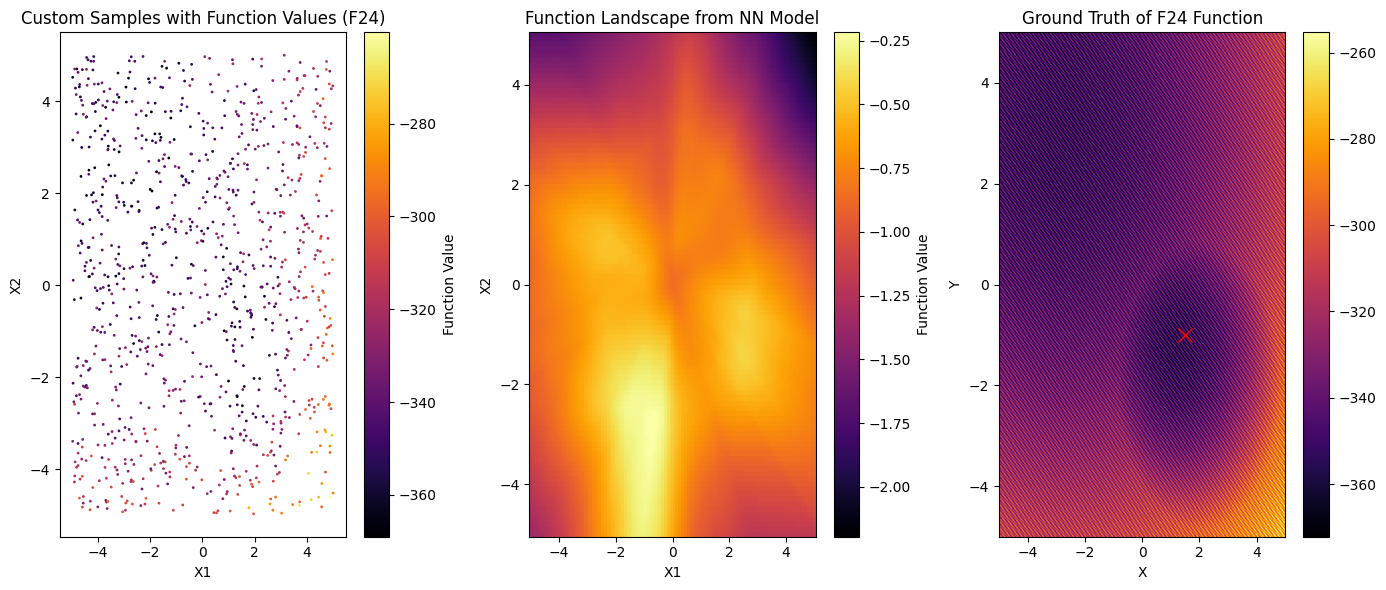

In [155]:
# Plot the sampled points
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.scatter(samples[:, 0], samples[:, 1], c=results, cmap='inferno', s=1)
plt.colorbar(label='Function Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Custom Samples with Function Values (F24)')

# Plot the predicted function values using a contour plot
plt.subplot(1, 3, 2)
plt.pcolormesh(X, Y, mesh_results, cmap='inferno', shading='nearest')
plt.colorbar(label='Function Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Function Landscape from NN Model')

# Plot the ground truth using a contour plot
plt.subplot(1, 3, 3)
xlim=(-5, 5)
step=0.01
ranges = [torch.arange(xlim[0], xlim[1] + step, step=step) for _ in range(n_dim)]
meshgrid = torch.meshgrid(*ranges)
points = torch.stack(meshgrid, dim=-1).view(-1, n_dim)

gt_results = problem(points)

grid_size = int((xlim[1] - xlim[0]) / step) + 1
x = points[:, 0].reshape(grid_size, grid_size)
y = points[:, 1].reshape(grid_size, grid_size)
z = gt_results.reshape(grid_size, grid_size)

# Create a pcolormesh plot
plt.pcolormesh(x, y, z, cmap='inferno', shading='nearest')
plt.colorbar()
plt.plot(problem.x_opt[0], problem.x_opt[1], 'rx', markersize=10, label='x_opt')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth of F24 Function')


plt.tight_layout()
plt.show()

## Simulation with Monte Carlo Simulation


XXX until now just taken from the internet

In [165]:
# Step 2: Generate random samples for Monte Carlo simulation
num_samples = 100
monte_carlo_samples = np.random.uniform(-5.0, 5.0, size=(num_samples, 2))

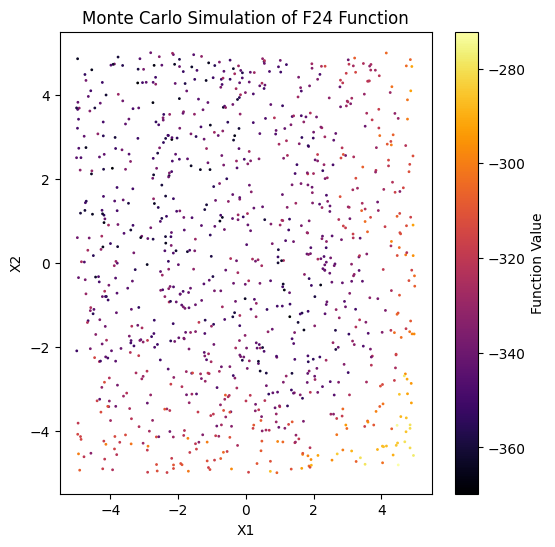

In [169]:
# Step 1: Create the F24 function with dimensionality 2 using bbobtorch (same as before)
dimensionality = 2
f24_function = bbobtorch.create_f24(dimensionality, seed=42)  # seed is optional

# Step 2: Generate random samples for Monte Carlo simulation
num_samples = 1000
monte_carlo_samples = np.random.uniform(-5.0, 5.0, size=(num_samples, dimensionality))

# Step 3: Evaluate the F24 function on the Monte Carlo samples
monte_carlo_results = f24_function(torch.tensor(monte_carlo_samples, dtype=torch.float32))

# Step 4: Plot the Monte Carlo simulation results
plt.figure(figsize=(6, 6))
plt.scatter(monte_carlo_samples[:, 0], monte_carlo_samples[:, 1], c=monte_carlo_results, cmap='inferno', s=1)
plt.colorbar(label='Function Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Monte Carlo Simulation of F24 Function')

plt.show()

c:\Users\Pascal\DataScience\Anaconda\envs\MachineLearningProject\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


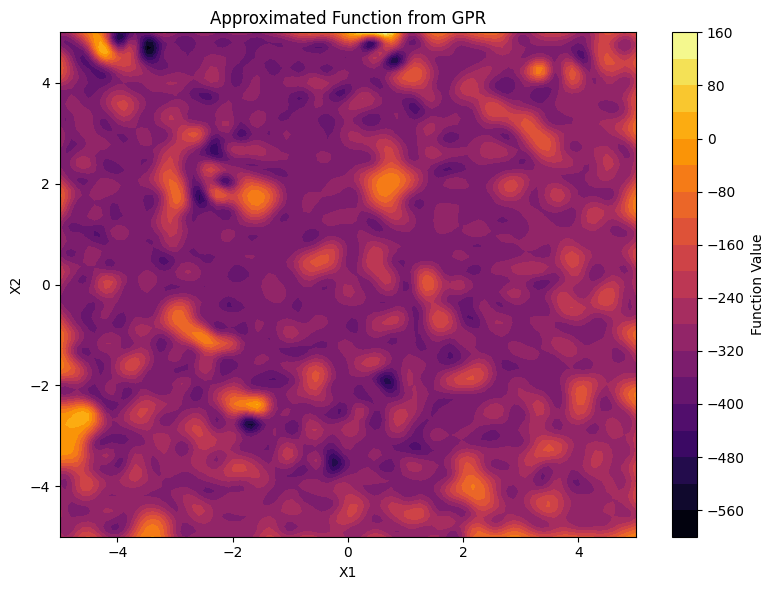

In [170]:
# Use Gaussian Process Regression to approximate the function
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process Regression model to the Monte Carlo samples
gpr_model.fit(monte_carlo_samples, monte_carlo_results)

# Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the GPR model on the mesh grid
mesh_results, _ = gpr_model.predict(mesh_samples, return_std=True)
mesh_results = mesh_results.reshape(X.shape)

# Plot the approximated function from GPR
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, mesh_results, levels=20, cmap='inferno')
plt.colorbar(label='Function Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Approximated Function from GPR')

plt.tight_layout()
plt.show()

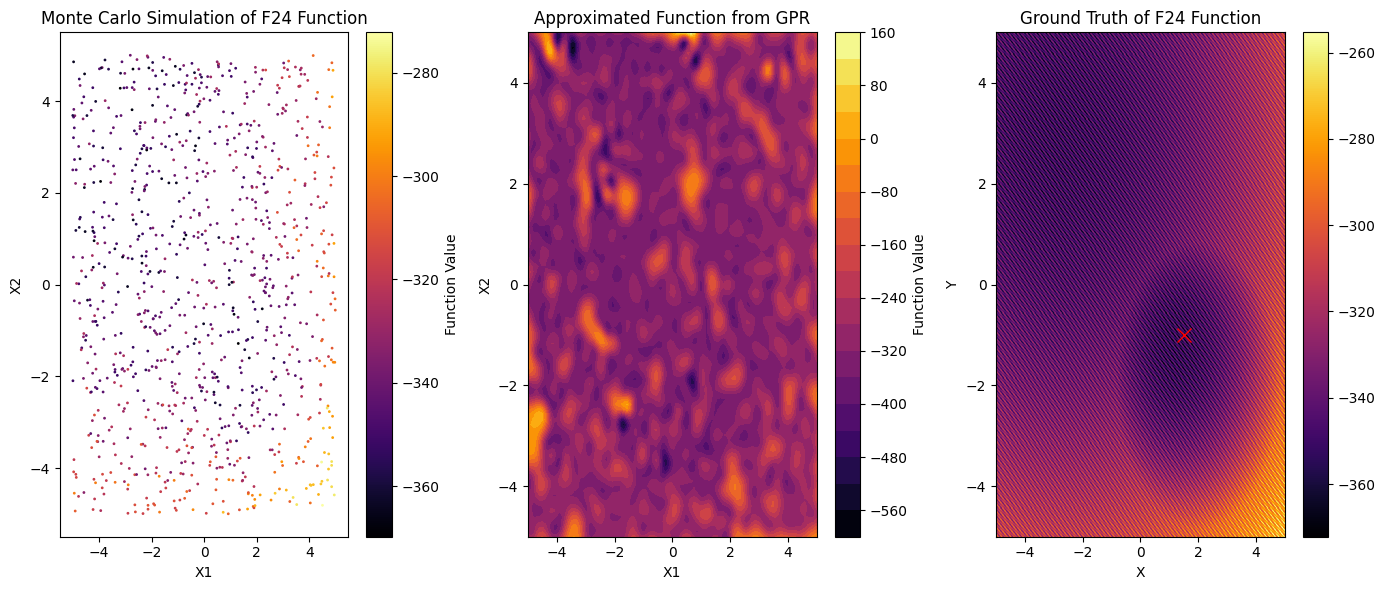

In [172]:
# Plot the sampled points
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.scatter(monte_carlo_samples[:, 0], monte_carlo_samples[:, 1], c=monte_carlo_results, cmap='inferno', s=1)
plt.colorbar(label='Function Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Monte Carlo Simulation of F24 Function')

# Plot the predicted function
plt.subplot(1, 3, 2)
plt.contourf(X, Y, mesh_results, levels=20, cmap='inferno')
plt.colorbar(label='Function Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Approximated Function from GPR')

# Plot the ground truth function
plt.subplot(1, 3, 3)
xlim=(-5, 5)
step=0.01
ranges = [torch.arange(xlim[0], xlim[1] + step, step=step) for _ in range(n_dim)]
meshgrid = torch.meshgrid(*ranges)
points = torch.stack(meshgrid, dim=-1).view(-1, n_dim)

gt_results = problem(points)

grid_size = int((xlim[1] - xlim[0]) / step) + 1
x = points[:, 0].reshape(grid_size, grid_size)
y = points[:, 1].reshape(grid_size, grid_size)
z = gt_results.reshape(grid_size, grid_size)

# Create a pcolormesh plot
plt.pcolormesh(x, y, z, cmap='inferno', shading='nearest')
plt.colorbar()
plt.plot(problem.x_opt[0], problem.x_opt[1], 'rx', markersize=10, label='x_opt')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth of F24 Function')


plt.tight_layout()
plt.show()

## Simulation with Support Vector Regression

In [173]:
from sklearn.svm import SVR

In [197]:
# simulate the function with the aboth samples and results
X_svc = samples
y_svc = results.float()

In [198]:
# define svr model
# XXX parameters are not optimized
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the SVR model to the Monte Carlo samples
svr_model.fit(X, y_svc)


SVR()

In [199]:
#Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the SVR model on the mesh grid
mesh_results = svr_model.predict(mesh_samples)
mesh_results = mesh_results.reshape(X.shape)

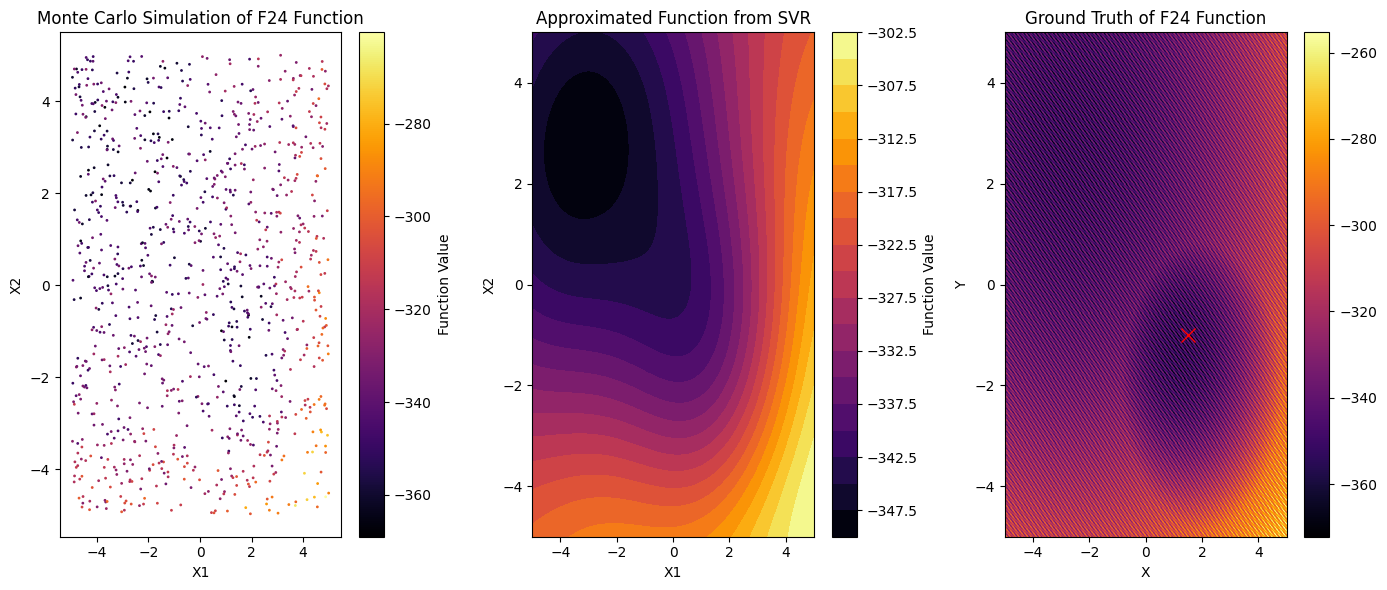

In [204]:
# Plot the sampled points
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.scatter(X_svc[:, 0], X_svc[:, 1], c=y_svc, cmap='inferno', s=1)
plt.colorbar(label='Function Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Monte Carlo Simulation of F24 Function')

# Plot the approximated function from SVR
plt.subplot(1, 3, 2)
plt.contourf(X, Y, mesh_results, levels=20, cmap='inferno')
plt.colorbar(label='Function Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Approximated Function from SVR')

# Plot the ground truth function
plt.subplot(1, 3, 3)
xlim=(-5, 5)
step=0.01
ranges = [torch.arange(xlim[0], xlim[1] + step, step=step) for _ in range(n_dim)]
meshgrid = torch.meshgrid(*ranges)
points = torch.stack(meshgrid, dim=-1).view(-1, n_dim)

gt_results = problem(points)

grid_size = int((xlim[1] - xlim[0]) / step) + 1
x = points[:, 0].reshape(grid_size, grid_size)
y = points[:, 1].reshape(grid_size, grid_size)
z = gt_results.reshape(grid_size, grid_size)

# Create a pcolormesh plot
plt.pcolormesh(x, y, z, cmap='inferno', shading='nearest')
plt.colorbar()
plt.plot(problem.x_opt[0], problem.x_opt[1], 'rx', markersize=10, label='x_opt')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth of F24 Function')


plt.tight_layout()
plt.show()